## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, f1_score
import itertools

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import binarize
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## Import DataFrame

In [2]:
raw_df = pd.read_stata('1NHANES.dta')

# lower column names
raw_df.columns = [col.lower() for col in raw_df.columns]

## Clean DataFrame

In [3]:
# Physician Diabetes Dx
# 0 = No Dx; 1 = Yes Dx
raw_df['diq010'] = raw_df['diq010'].apply(lambda x: np.nan if (x == 3) |
                                          (x == 7) | (x == 9) else x)
raw_df['diq010'] = raw_df['diq010'].apply(lambda x: 0 if x == 2 else x)

# Sex
# 0 = Female; 1 = Male
raw_df['riagendr'] = raw_df['riagendr'].apply(lambda x: 0 if (x == 2) else x)

# Education
# HS and less = 0, less than college = 1, college or above = 2
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: np.nan
                                              if (x == 7) | (x == 9) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 0 if (x <= 3) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 1 if (x == 4) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 2 if (x == 5) else x)

# Citizenship
# 0 = No citizenship, 1 = Citizensip
raw_df['dmdcitzn'] = raw_df['dmdcitzn'].apply(lambda x: np.nan
                                              if (x == 7) | (x == 9) else x)
raw_df['dmdcitzn'] = raw_df['dmdcitzn'].apply(lambda x: 0 if x == 2 else x)

# Alcohol
# 1 = Yes, 0 = No
raw_df['alq101'] = raw_df['alq101'].apply(lambda x: np.nan if (x == 9) else x)
raw_df['alq101'] = raw_df['alq101'].apply(lambda x: 0 if (x == 2) else x)

# Veteran
# 1 = No, 0 = Yes
raw_df['dmqmiliz'] = raw_df['dmqmiliz'].apply(lambda x: np.nan
                                              if (x == 7) else x)
raw_df['dmqmiliz'] = raw_df['dmqmiliz'].apply(lambda x: 0 if (x == 2) else x)

# Smoke
# 1 = Yes, 0 = No
raw_df['smq020'] = raw_df['smq020'].apply(lambda x: np.nan
                                          if (x == 7) | (x == 9) else x)
raw_df['smq020'] = raw_df['smq020'].apply(lambda x: 0 if x == 2 else x)

# Moderate Physical Activity
# 1 = Yes, 0 = No
raw_df['paq620'] = raw_df['paq620'].apply(lambda x: np.nan
                                          if (x == 7) | (x == 9) else x)
raw_df['paq620'] = raw_df['paq620'].apply(lambda x: 0 if x == 2 else x)

# Diabetes - Clean after imputing missing values to appropriately categorize 0, 1, 2
df_y = raw_df['lbxgh']

## Predictors
predictors = [
    ('age', 'ridageyr'),
    ('bmi', 'bmxbmi'),
    ('bun', 'lbxsbu'),
    ('race', 'ridreth3'),
    ('education', 'dmdeduc2'),
    ('sex', 'riagendr'),
    ('diabetes_dx', 'diq010'),
    ('citizen', 'dmdcitzn'),
    ('alcohol', 'alq101'),
    ('veteran', 'dmqmiliz'),
    ('smoke', 'smq020'),
    ('systolicBP', 'bpxsy2'),
    ('ast', 'lbxsassi'),
    ('alt', 'lbxsatsi'),
]

dummies = [
    ('diabetes_dx', 'diq010'),
    ('race', 'ridreth3'),
    ('education', 'dmdeduc2'),
    ('sex', 'riagendr'),
    ('alcohol', 'alq101'),
    ('veteran', 'dmqmiliz'),
    ('smoke', 'smq020'),
    ('citizen', 'dmdcitzn'),
]

# Convert categorical variables into dummies - Don't Fall for Dummy Trap
cat_df = pd.DataFrame([])
for dum in dummies:
    cat_df[dum[0]] = raw_df[dum[1]]
    cat_df = pd.get_dummies(cat_df.astype('object'), drop_first=True)

cont_df = pd.DataFrame([])
for pred in predictors:
    cont_df[pred[0]] = raw_df[pred[1]]

# Concatenate predictors
df_x = pd.concat([cat_df, cont_df], axis=1)
# Concatenate dependent and predictors
df_main = pd.concat([df_y, df_x], axis=1)  # LOOK

# Rename column names
df = df_main.copy()
df = df.rename(
    columns={
        'lbxgh': 'diabetes',
        'race_2_1': 'Other Hispanic',
        'race_3_1': 'NH White',
        'race_4_1': 'NH Black',
        'race_6_1': 'Asian',
        'race_7_1': 'Others',
        'education_1.0': 'College - Not Graduated or Associates',
        'education_2.0': 'College degree or Above',
        'riagendr': 'sex',
        'diq010': 'diabetes_dx',
        'dmdcitzn': 'citizen',
        'alq101': 'alcohol',
        'dmqmiliz': 'veteran',
        'smq020': 'smoke',
        'bpxsy2': 'systolicBP',
        'lbxsatsi': 'alt',
        'lbxsassi': 'ast',
        'paq620': 'physical activity'
    })

# Final Dataframe
df = df.drop([
    'diabetes_dx', 'race', 'education', 'sex', 'alcohol', 'veteran', 'smoke',
    'citizen'
],
             axis=1)

## EDA

In [4]:
df.head()

,diabetes,diabetes_dx_1.0_1_1_1_1_1_1_1,race_2.0_1_1_1_1_1_1,race_3.0_1_1_1_1_1_1,race_4.0_1_1_1_1_1_1,race_6.0_1_1_1_1_1_1,race_7.0_1_1_1_1_1_1,education_1.0_1_1_1_1_1,education_2.0_1_1_1_1_1,sex_1.0_1_1_1_1,alcohol_1.0_1_1_1,veteran_1.0_1_1,smoke_1.0_1,citizen_1.0,age,bmi,bun,systolicBP,ast,alt
0,5.1,0,0,1,0,0,0,0,0,1,0,0,0,1,22.0,23.3,14.0,104.0,25.0,19.0
1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,14.2,NaN,NaN,NaN,NaN
2,5.5,0,0,0,0,1,0,0,0,1,0,0,0,1,14.0,17.3,16.0,108.0,19.0,13.0
3,4.9,0,0,1,0,0,0,1,0,0,0,1,0,1,44.0,23.2,5.0,118.0,37.0,29.0
4,5.9,0,0,0,1,0,0,0,0,0,0,0,0,1,14.0,27.2,12.0,104.0,19.0,13.0


In [5]:
df.shape

(29902, 20)

In [6]:
df.dtypes

diabetes                         float64
diabetes_dx_1.0_1_1_1_1_1_1_1      uint8
race_2.0_1_1_1_1_1_1               uint8
race_3.0_1_1_1_1_1_1               uint8
race_4.0_1_1_1_1_1_1               uint8
race_6.0_1_1_1_1_1_1               uint8
race_7.0_1_1_1_1_1_1               uint8
education_1.0_1_1_1_1_1            uint8
education_2.0_1_1_1_1_1            uint8
sex_1.0_1_1_1_1                    uint8
alcohol_1.0_1_1_1                  uint8
veteran_1.0_1_1                    uint8
smoke_1.0_1                        uint8
citizen_1.0                        uint8
age                              float64
bmi                              float64
bun                              float64
systolicBP                       float64
ast                              float64
alt                              float64
dtype: object

diabetes                         0.360779
diabetes_dx_1.0_1_1_1_1_1_1_1    0.000000
race_2.0_1_1_1_1_1_1             0.000000
race_3.0_1_1_1_1_1_1             0.000000
race_4.0_1_1_1_1_1_1             0.000000
race_6.0_1_1_1_1_1_1             0.000000
race_7.0_1_1_1_1_1_1             0.000000
education_1.0_1_1_1_1_1          0.000000
education_2.0_1_1_1_1_1          0.000000
sex_1.0_1_1_1_1                  0.000000
alcohol_1.0_1_1_1                0.000000
veteran_1.0_1_1                  0.000000
smoke_1.0_1                      0.000000
citizen_1.0                      0.000000
age                              0.000000
bmi                              0.116681
bun                              0.371848
systolicBP                       0.276637
ast                              0.372082
alt                              0.371982
dtype: float64


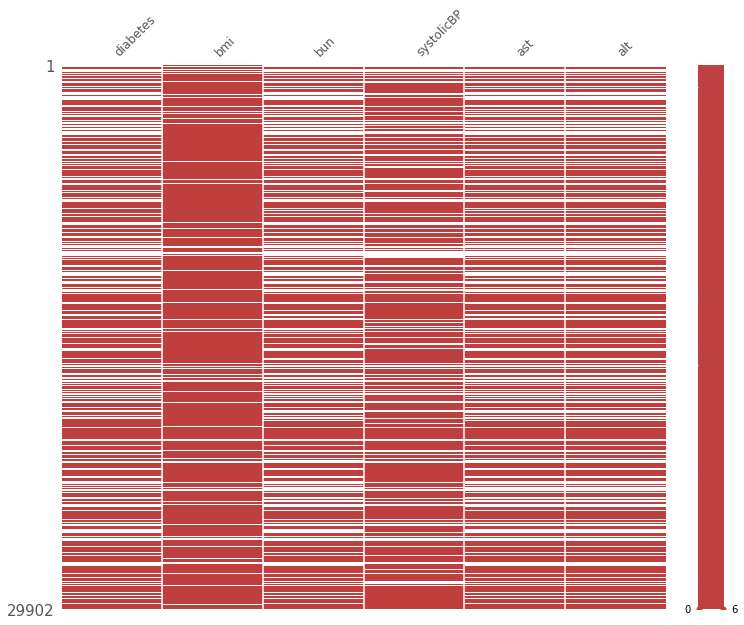

In [7]:
print(df.isna().sum() / len(df))
missingdata_df = df.columns[df.isnull().any()].tolist()
# Missing Data Heatmap
msno.matrix(df[missingdata_df],
            figsize=(12, 10),
            fontsize=12,
            color=(0.75, 0.25, 0.25))
plt.show()

In [8]:
dummies = [
    'diabetes_dx_1.0_1_1_1_1_1_1_1', 'race_2.0_1_1_1_1_1_1',
    'race_3.0_1_1_1_1_1_1', 'race_4.0_1_1_1_1_1_1', 'race_6.0_1_1_1_1_1_1',
    'race_7.0_1_1_1_1_1_1', 'sex_1.0_1_1_1_1', 'alcohol_1.0_1_1_1',
    'veteran_1.0_1_1', 'smoke_1.0_1', 'citizen_1.0'
]

df_dummies = df[dummies]
df_no_dummies = df.drop(columns=(dummies), axis=1)

In [9]:
# Multiple Imputation
# no dummies
MICE_imputer = IterativeImputer()
df_MICE = df_no_dummies.copy(deep=True)
df_MICE.iloc[:, :] = MICE_imputer.fit_transform(df_MICE)

# dummies
MICE_imputer2 = IterativeImputer()
df_dummies_MICE = df_dummies.copy(deep=True)
df_dummies_MICE.iloc[:, :] = MICE_imputer2.fit_transform(df_dummies_MICE)
df_dummies_MICE = df_dummies_MICE.astype(int)

df_full = pd.concat([df_MICE, df_dummies_MICE], axis=1)

In [10]:
dummy_names = {
    'diabetes_dx_1.0_1_1_1_1_1_1_1': 'diab_dx',
    'education_1.0_1_1_1_1_1': 'College_NotGraduated_or_Associates',
    'education_2.0_1_1_1_1_1': 'College_Degree_or_Above',
    'race_2.0_1_1_1_1_1_1': 'Race_Other_Hispanic',
    'race_3.0_1_1_1_1_1_1': 'Race_NH_White',
    'race_4.0_1_1_1_1_1_1': 'Race_NH_Black',
    'race_6.0_1_1_1_1_1_1': 'Race_Asian',
    'race_7.0_1_1_1_1_1_1': 'Race_Other',
    'sex_1.0_1_1_1_1': 'Sex',
    'alcohol_1.0_1_1_1': 'Alcohol',
    'veteran_1.0_1_1': 'Veteran',
    'smoke_1.0_1': 'Smoker',
    'citizen_1.0': 'US_citizen'
}

df_full = df_full.rename(columns=dummy_names)

In [11]:
df_full.head()

,diabetes,College_NotGraduated_or_Associates,College_Degree_or_Above,age,bmi,bun,systolicBP,ast,alt,diab_dx,Race_Other_Hispanic,Race_NH_White,Race_NH_Black,Race_Asian,Race_Other,Sex,Alcohol,Veteran,Smoker,US_citizen
0,5.100000,0.0,0.0,22.0,23.3,14.000000,104.00000,25.000000,19.000000,0,0,1,0,0,0,1,0,0,0,1
1,4.757934,0.0,0.0,3.0,14.2,8.746796,98.58602,23.437948,18.427252,0,0,0,0,0,0,0,0,0,0,1
2,5.500000,0.0,0.0,14.0,17.3,16.000000,108.00000,19.000000,13.000000,0,0,0,0,1,0,1,0,0,0,1
3,4.900000,1.0,0.0,44.0,23.2,5.000000,118.00000,37.000000,29.000000,0,0,1,0,0,0,0,0,1,0,1
4,5.900000,0.0,0.0,14.0,27.2,12.000000,104.00000,19.000000,13.000000,0,0,0,1,0,0,0,0,0,0,1


###  A1c --> Non-Diabetes, Pre-diabetes, Diabetes (Raw and NA Imputed DF)

In [12]:
df['diabetes'] = df['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if (x >= 6.5) else x)

df_full['diabetes'] = df_full['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df_full['diabetes'] = df_full['diabetes'].apply(lambda x: 1
                                                if (x >= 6.5) else x)

Text(0.5, 0, 'Diabetes')

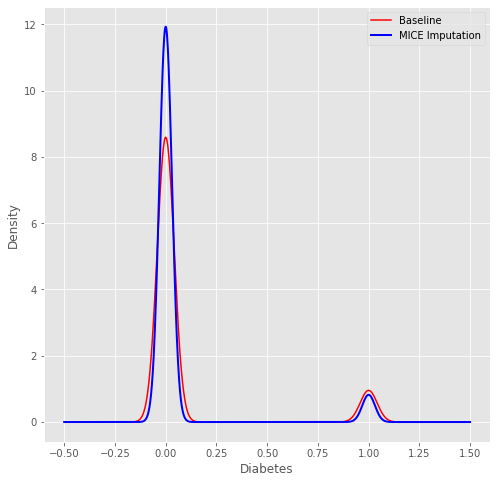

In [13]:
# Plot Missing NaN Imputation
fig, ax = plt.subplots(figsize=(8, 8))
df['diabetes'].dropna().plot(kind='kde', c='red')
df_full['diabetes'].plot(kind='kde', c='blue', linewidth=2)
labels = ['Baseline', 'MICE Imputation']
plt.legend(labels)
ax.set_xlabel('Diabetes')

In [14]:
def get_target(df):
    df.loc[(df['diabetes'] == 0) & (df['diab_dx'] == 0), 'dia_var'] = 0
    df.loc[(df['diabetes'] == 1) & (df['diab_dx'] == 0), 'dia_var'] = 1
    df.loc[(df['diabetes'] == 1) & (df['diab_dx'] == 1), 'dia_var'] = 2
    df = df.drop(columns=['diabetes', 'diab_dx'], axis=1)
    return df


df_full2 = get_target(df_full)

In [15]:
df_full2.dia_var.isna().sum()

860

In [16]:
# Drop lagging NAs
df = df.dropna(axis=0)
df_full2 = df_full2.dropna(axis=0)

In [17]:
df_copy = df_full2.copy()
df_copy2=df_copy.drop(columns=([i for i in dummy_names.values() if i not in ['diab_dx']]),axis=1)
df_copy3=df_copy.drop(columns=([i for i in df_copy.columns if i not in dummy_names.values()]),axis=1)
df_copy3=pd.concat([df_copy.dia_var,df_copy3],axis=1)

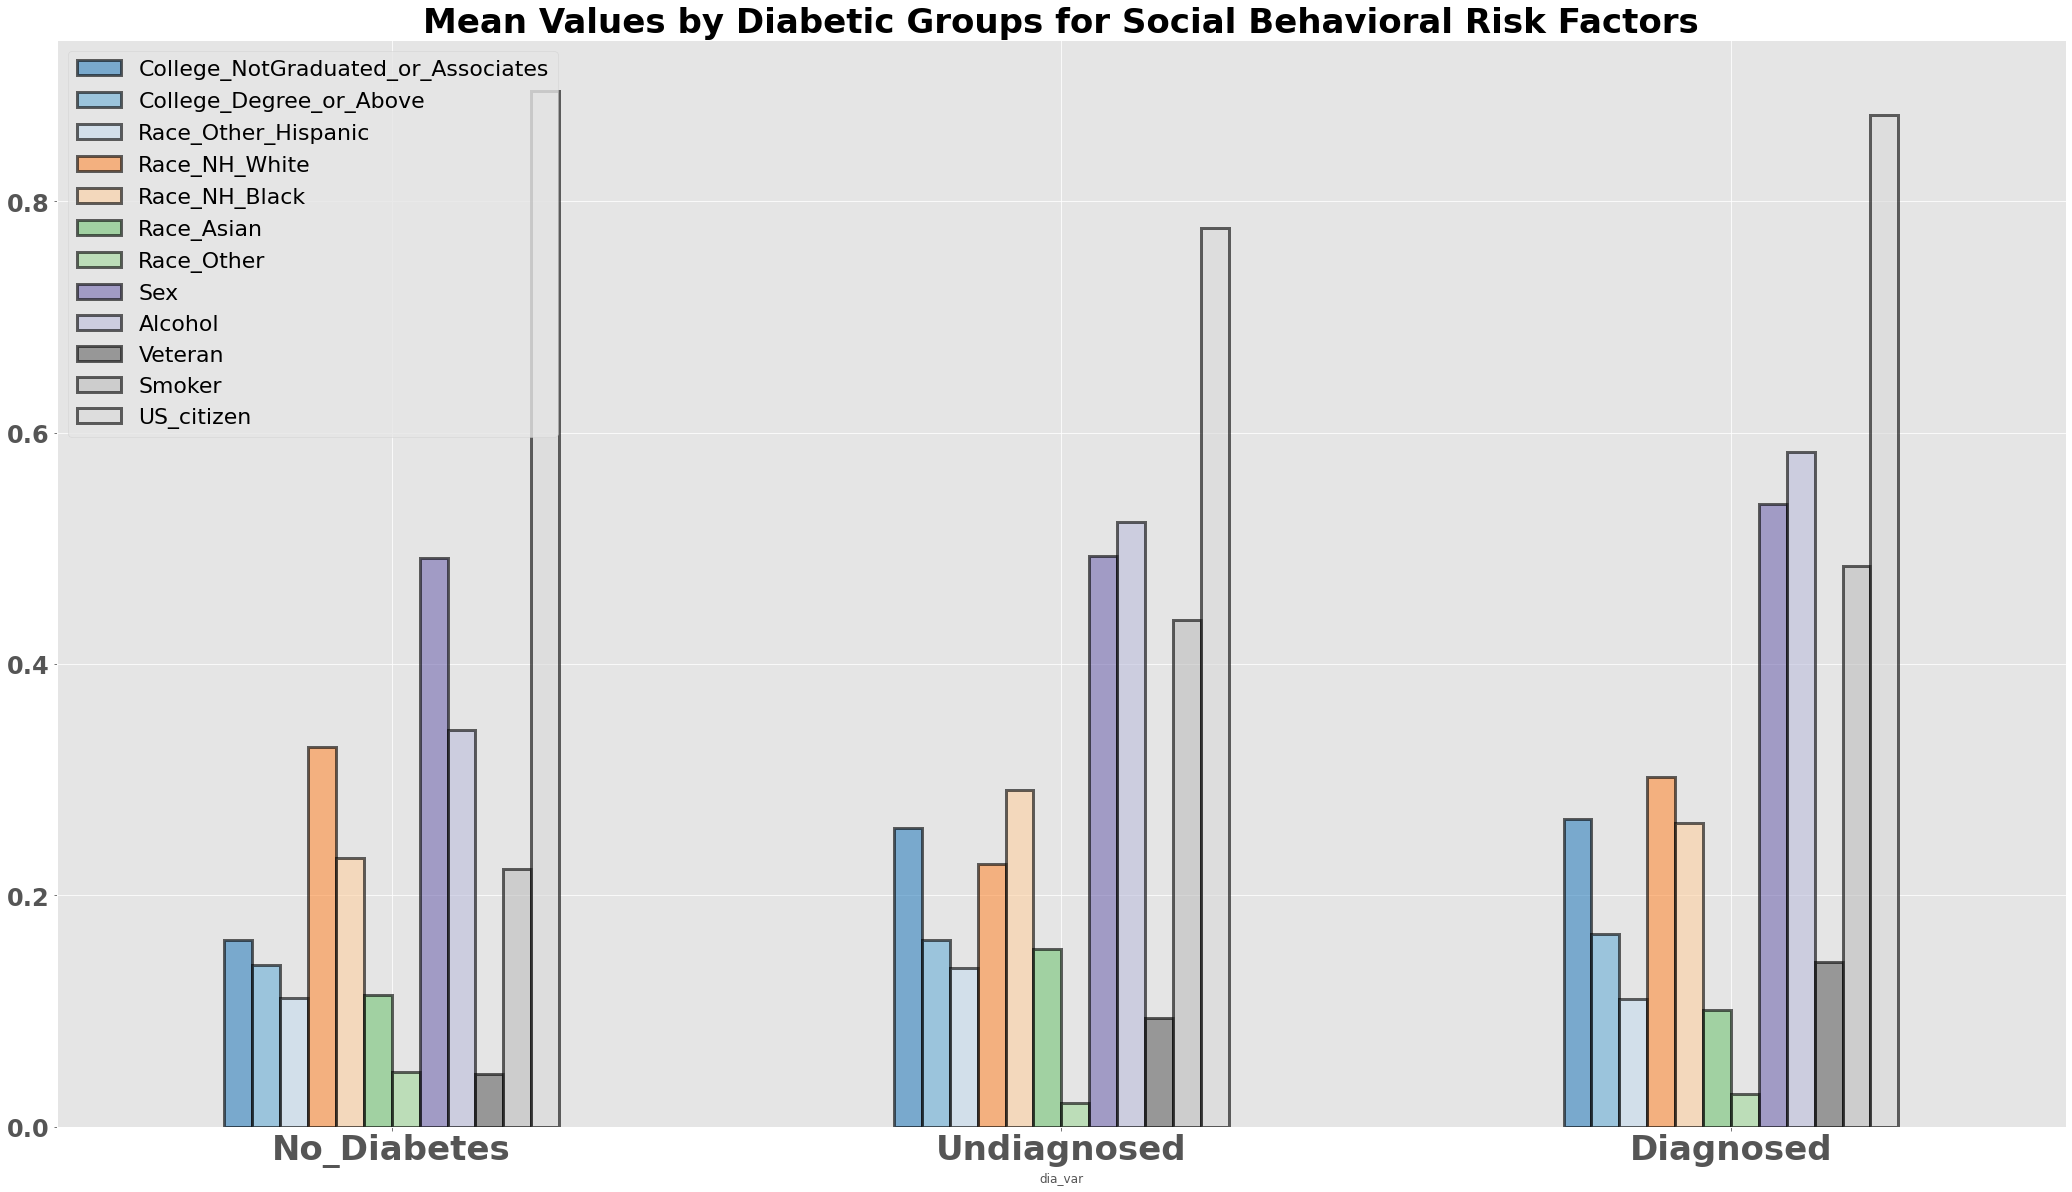

In [18]:
df_copy3.groupby('dia_var').mean().plot(kind='bar',
                                        figsize=(36, 20),
                                        edgecolor='black',
                                        linewidth=3,
                                        alpha=0.6,
                                        cmap='tab20c'
                                       )
plt.title('Mean Values by Diabetic Groups for Social Behavioral Risk Factors', 
          fontdict={"fontsize":34,"fontweight":"black"})
plt.legend(fontsize=22,loc='upper left')
labels = ['No_Diabetes', 'Undiagnosed', 'Diagnosed']
plt.xticks(ticks=np.arange(len(df_full2['dia_var'].unique())),
           labels=labels,
           rotation=0,
           fontsize=34,
           fontweight='black')
plt.yticks(fontsize=24, fontweight='black')
plt.show()

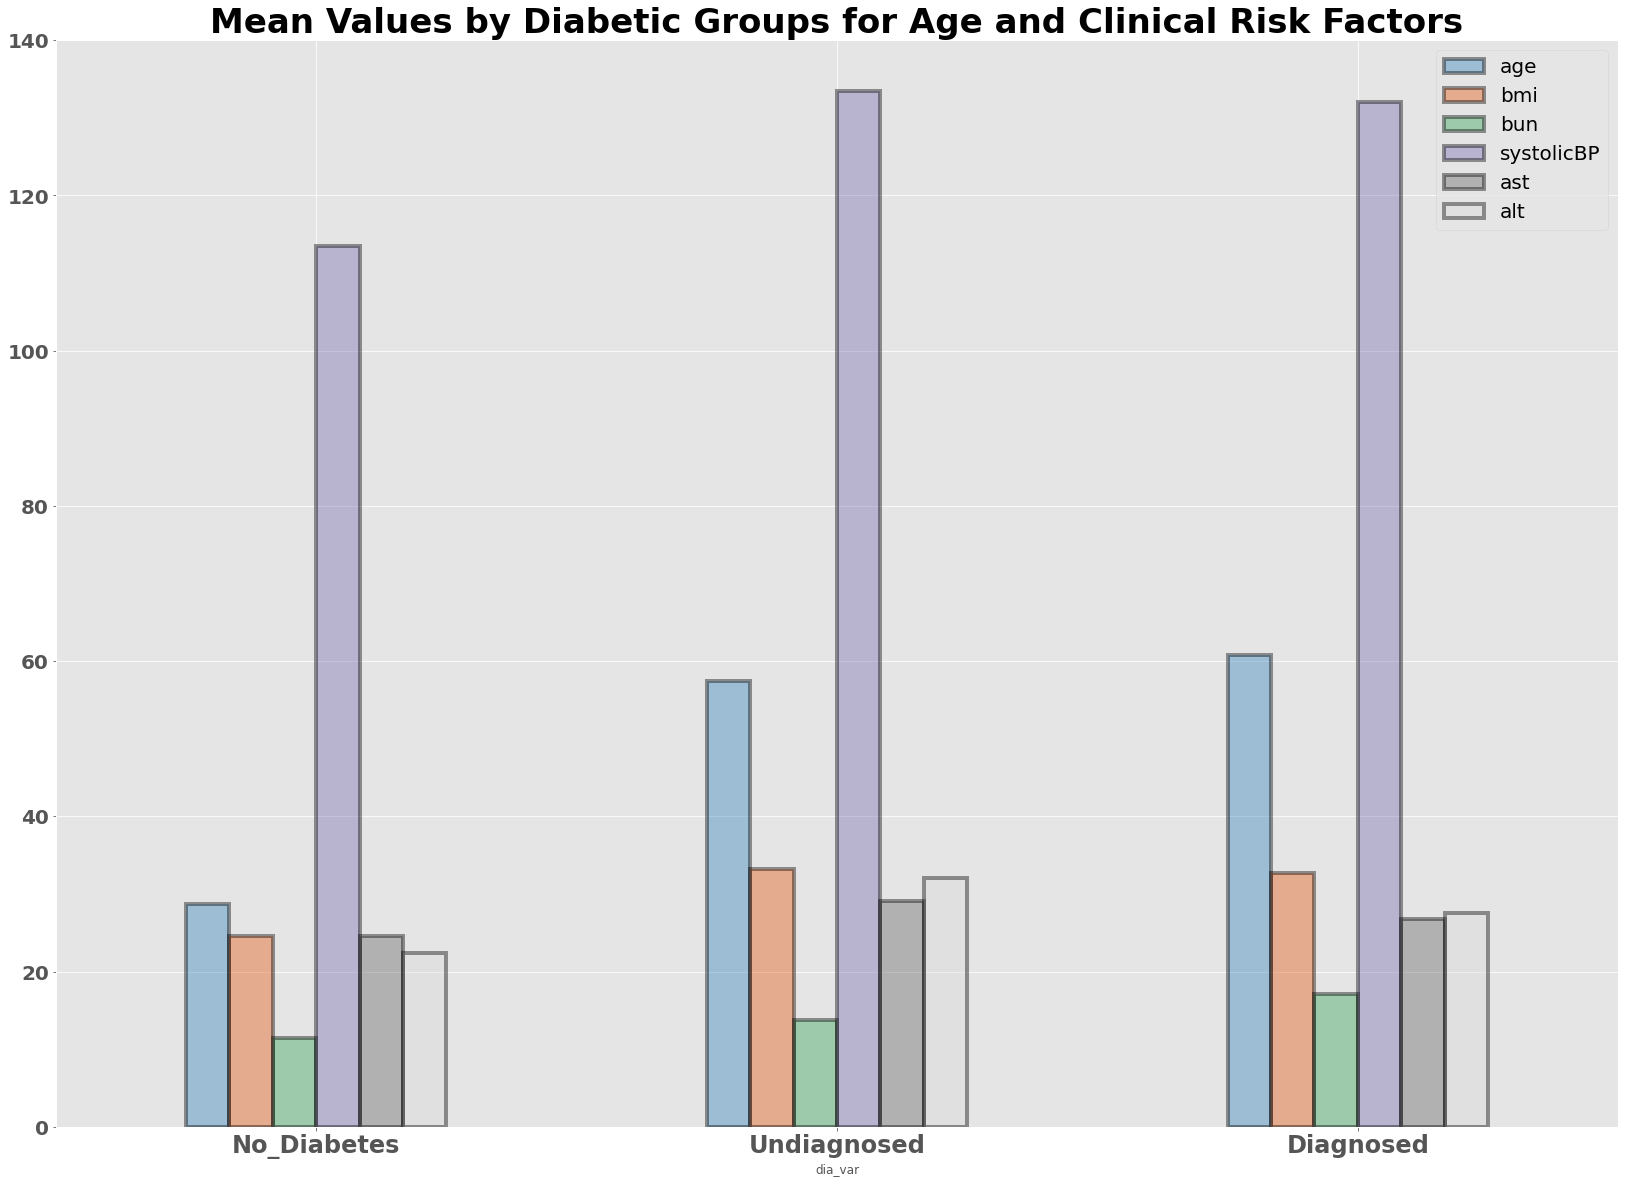

In [19]:
df_copy2.groupby('dia_var').mean().plot(kind='bar',
                                        figsize=(28, 20),
                                        edgecolor='black',
                                        linewidth=4,
                                        alpha=0.4,
                                        cmap='tab20c'
                                       )
plt.title('Mean Values by Diabetic Groups for Age and Clinical Risk Factors', 
          fontdict={"fontsize":34,"fontweight":"black"})
plt.legend(fontsize=20)
labels = ['No_Diabetes', 'Undiagnosed', 'Diagnosed']
plt.xticks(ticks=np.arange(len(df_full2['dia_var'].unique())),
           labels=labels,
           rotation=0,
           fontsize=24,
           fontweight='black')
plt.yticks(fontsize=20, fontweight='black')
plt.show()

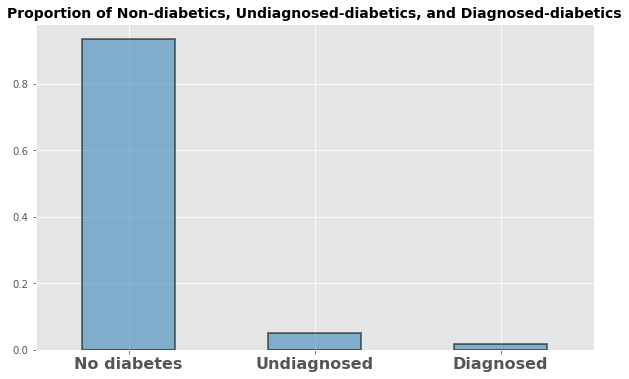

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = df_full2.dia_var.value_counts(normalize=True).plot(kind='bar',
                                                        cmap='tab10',
                                                        alpha=0.5,
                                                        ax=ax,
                                                        linewidth=2,
                                                        edgecolor='black')
ax.set_title('Proportion of Non-diabetics, Undiagnosed-diabetics, and Diagnosed-diabetics',
             fontdict={'fontsize':14, 'fontweight':'black'}
            )
ax.set_xticklabels(['No diabetes', 'Undiagnosed', 'Diagnosed'],
                   fontdict={
                       'fontsize': 16,
                       'rotation': 0,
                       'fontweight': "black"
                   })
plt.show();

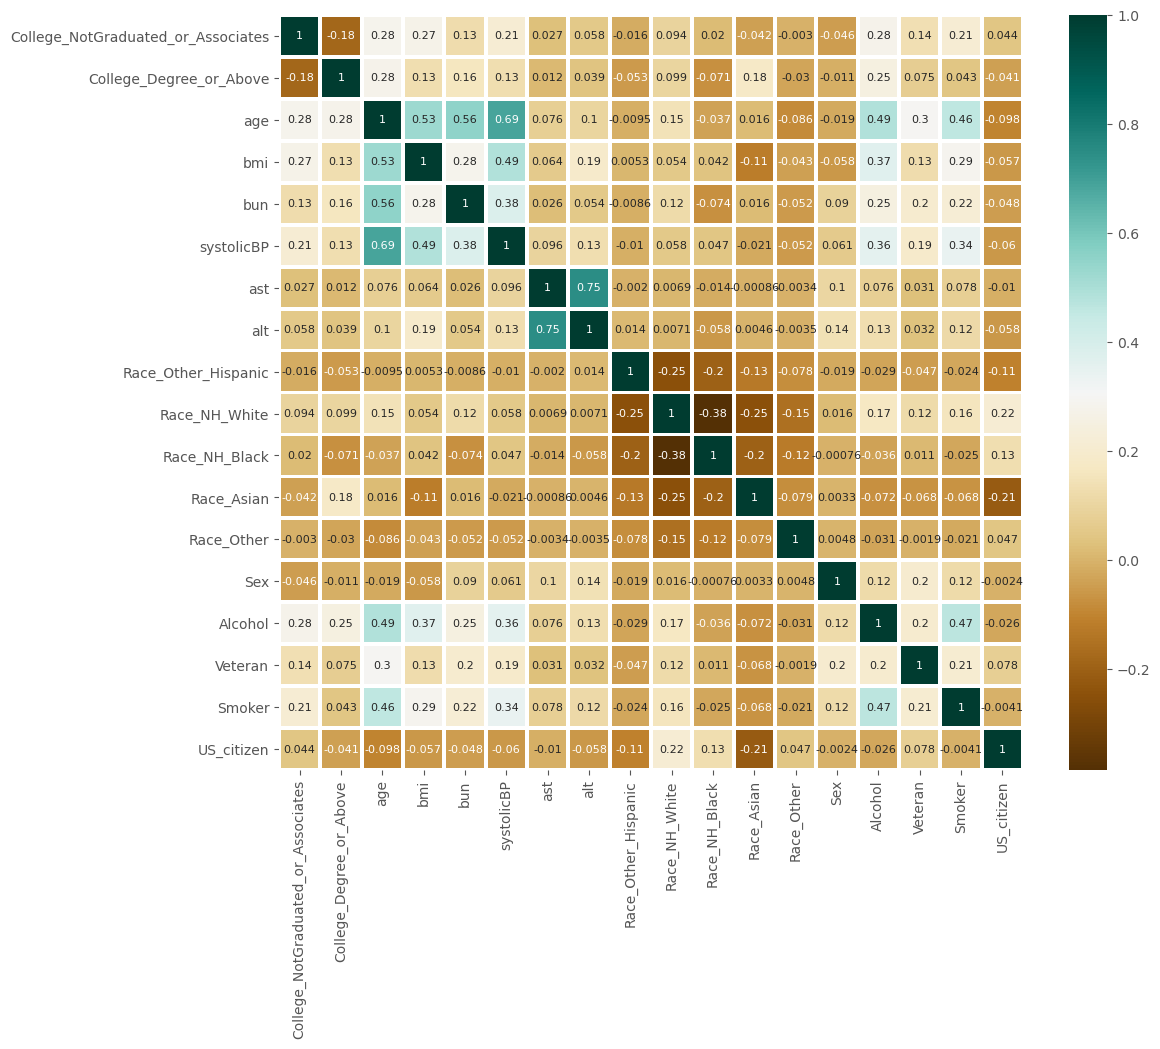

In [21]:
# Heatmap
plt.figure(figsize=(12, 10), dpi=100)
c = df_full2.set_index('dia_var').corr()
sns.heatmap(
    c,
    cmap='BrBG',
    annot=True,
    linewidths=2,
    linecolor='white',
    annot_kws={'fontsize': 8},
)
plt.show();

### Preprocess

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
normalize = Normalizer()
scaler = StandardScaler()


In [23]:
y = df_full2.dia_var
X = df_full2.drop(columns='dia_var', axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y.tolist())

In [25]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
normalize.fit(X_train)
X_train = normalize.transform(X_train)
X_test = normalize.transform(X_test)

### Logistic Regression - OVR

In [27]:
def logistic(X_train, X_test, y_train, y_test):

    logreg = LogisticRegression(multi_class='ovr', class_weight='balanced')
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)

    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, y_pred)
    print(classification_report(y_test, y_pred))

    return cm, classes, logreg, cr


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix - Logistic Regression',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix - Logistic Regression')

    print(cm)
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

         0.0       0.99      0.73      0.84      5423
         1.0       0.07      0.63      0.13        98
         2.0       0.15      0.52      0.23       288

    accuracy                           0.72      5809
   macro avg       0.41      0.63      0.40      5809
weighted avg       0.93      0.72      0.80      5809

Normalized confusion matrix
[[0.72764153 0.12207265 0.15028582]
 [0.06122449 0.63265306 0.30612245]
 [0.10416667 0.375      0.52083333]]


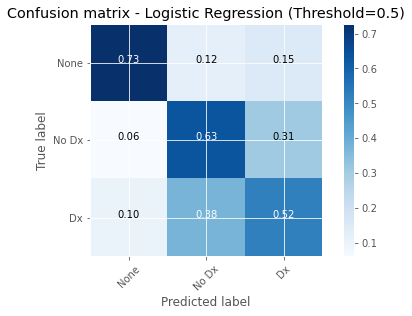

In [28]:
cm, classes, logreg, cr = logistic(X_train, X_test, y_train, y_test)

plot_confusion_matrix(
    cm,
    classes,
    normalize=True,
    title='Confusion matrix - Logistic Regression (Threshold=0.5)',
    cmap=plt.cm.Blues)

### Linear SVC - OVR

The accuracy score is 0.8063349974178
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      5423
         1.0       0.07      0.73      0.13        98
         2.0       0.28      0.13      0.18       288

    accuracy                           0.81      5809
   macro avg       0.44      0.57      0.40      5809
weighted avg       0.92      0.81      0.86      5809

Normalized confusion matrix
[[0.84362899 0.13940623 0.01696478]
 [0.2244898  0.73469388 0.04081633]
 [0.34722222 0.52430556 0.12847222]]


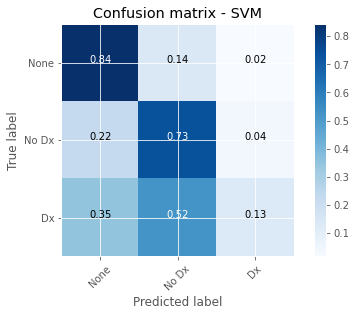

In [29]:
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score


def svm(X_train, X_test, y_train, y_test):

    svclassifier = LinearSVC(multi_class='ovr',
                             fit_intercept=True,
                             intercept_scaling=1,
                             class_weight='balanced',
                             loss='hinge',
                             C=55,
                             random_state=123)
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    print("The accuracy score is" + " " +
          str(recall_score(y_test, y_pred, average='micro')))
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred, labels=svclassifier.classes_)
    classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, y_pred, labels=svclassifier.classes_)
    print(classification_report(y_test, y_pred))
    f1 = f1_score(y_test, y_pred, average='micro')
    rs = recall_score(y_test, y_pred, average='micro')

    return cm, classes, svm, cr


cm, classes, svm, cr = svm(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm,
                      classes,
                      normalize=True,
                      title='Confusion matrix - SVM',
                      cmap=plt.cm.Blues)